# Optimization 2

In [1]:
using Distributed
using SharedArrays
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [9]:
@everywhere include("inverse_prob.jl")

# Background

In [3]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;

Fs = 500;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
# plot(t,source); title("ricker source")
source_position = zeros(11,2)
for i = 1:11
#     source_position[i,:] = [3,(i-1)*10+1]
    source_position[i,:] = [(i-1)*10+1,1]
end
source = repeat(source, 1, 11)

receiver_position = zeros(26,2)
for i = 1:26
#     receiver_position[i,:] = [1,(i-1)*2+1]
    receiver_position[i,:] = [(i-1)*4+1,101]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)

c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[25:end,:] .= 1.2;
c0[45:55,45:55] .= 1.2

c = imfilter(c0, Kernel.gaussian(40));
    
pml_len = 10
pml_coef=  100
end

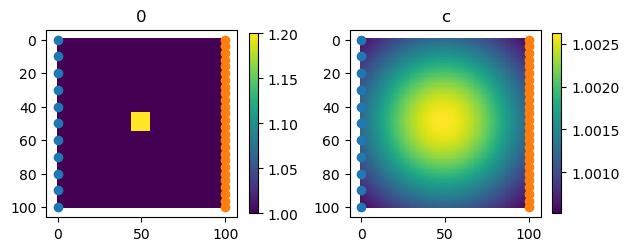

In [4]:
figure; 
subplot(121); imshow(c0); colorbar(shrink=0.4); title("0")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)
subplot(122); imshow(c); colorbar(shrink=0.4); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)
tight_layout()

## Build data

In [6]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

 29.438425 seconds (7.61 M allocations: 381.212 MiB, 0.80% gc time)
 23.952713 seconds (3.47 k allocations: 119.109 KiB)


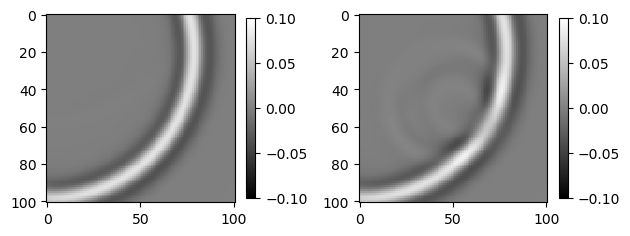

In [7]:
figure;
subplot(121); imshow(u[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u0[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

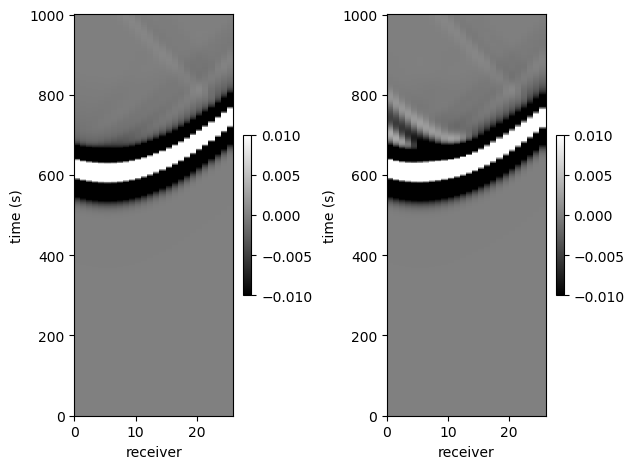

In [8]:
figure;
r_axis = 0:11
subplot(121); pcolor(data[:,:,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); pcolor(data0[:,:,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [7]:
# Test gradient
@time gg = grad_l2(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);

 93.121193 seconds (8.67 M allocations: 123.846 GiB, 17.69% gc time)


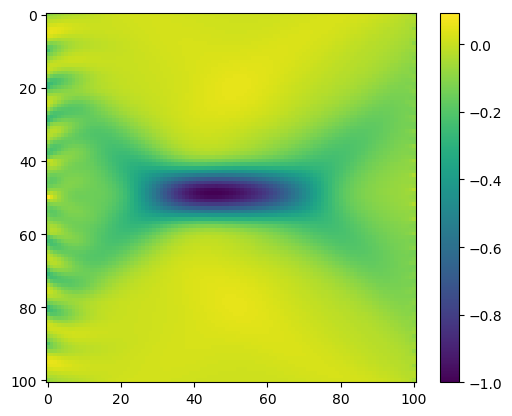

PyObject <matplotlib.colorbar.Colorbar object at 0x1474354a8>

In [8]:
imshow(gg); colorbar()

In [ ]:
## Test functions

In [10]:
obj_fn_gd(x) = obj_fn_parallel(x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100)

obj_fn_gd (generic function with 1 method)

In [35]:
xk = c[:]

fk, gradk = obj_fn_gd(xk);
println(fk)

1.3083493489058173


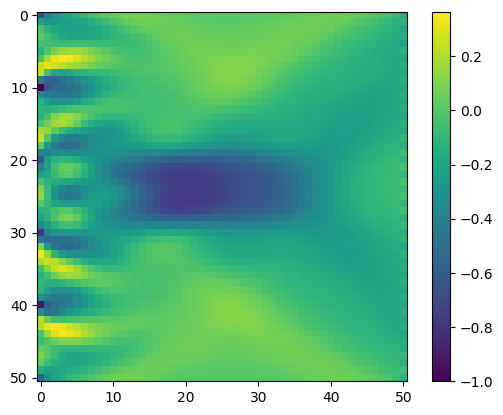

PyObject <matplotlib.colorbar.Colorbar object at 0x1420e89b0>

In [38]:
imshow(reshape(gradk,Nx,Ny)); colorbar()

In [46]:
pk = -gradk
alpha = 0.01
xkk = xk+alpha*pk
xkk[findall(ind->ind<1,xk)] .= 1
xkk[findall(ind->ind>1.2,xk)] .= 1.2
@time fk1, gradk1 = obj_fn_gd(xkk)
println(fk1)

 15.694345 seconds (1.21 M allocations: 21.962 GiB, 26.71% gc time)
1.16569451716923


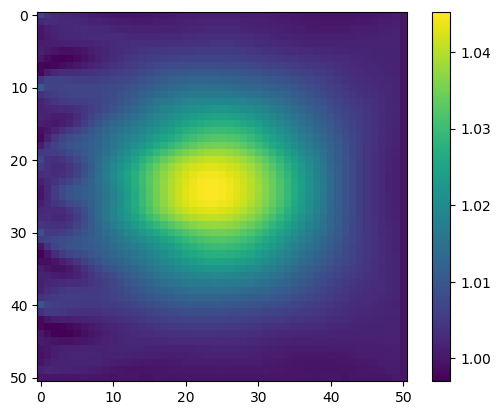

PyObject <matplotlib.colorbar.Colorbar object at 0x142f3c5c0>

In [48]:
imshow(reshape(xkk,Nx,Ny)); colorbar()

In [52]:
fk1 < fk + (1e-3)*alpha*sum(gradk.*pk)
(1e-3)*alpha*sum(gradk.*pk)

-0.001583801376672717

## Test line search

In [11]:
xkk, fkk, gradkk = line_search_backtracking(obj_fn_gd, c, fk, gradk, 0.1, 1, 1.2; rho=0.9, c=1e-3, maxSearchTime=3);

UndefVarError: UndefVarError: fk not defined

## Test Gradient descent

In [11]:
xxx, fff = gradient_descent(obj_fn_gd, c, 0.1, 5, 1, 1.2; rho=0.5, c=1e-3, maxSearchTime=3);

Main iteration: 1
Start line search, fk: 0.6595263202038681. fk1: 3.4653792836914397
Search time: 1. alpha: 0.05. fk1: 0.7914454865817969
Search time: 2. alpha: 0.025. fk1: 0.3507072191361156
Line search succeed. Search time: 2.
--------------------------------
Main iteration: 2
Start line search, fk: 0.3507072191361156. fk1: 1.0994883888818128
Search time: 1. alpha: 0.05. fk1: 0.24113660221836283
Line search succeed. Search time: 1.
--------------------------------
Main iteration: 3
Start line search, fk: 0.24113660221836283. fk1: 1.1492915512213437
Search time: 1. alpha: 0.05. fk1: 0.1648961929447154
Line search succeed. Search time: 1.
--------------------------------
Main iteration: 4
Start line search, fk: 0.1648961929447154. fk1: 1.5363769920098977
Search time: 1. alpha: 0.05. fk1: 0.47258591867349486
Search time: 2. alpha: 0.025. fk1: 0.21733499762832445
Search time: 3. alpha: 0.0125. fk1: 0.16544304412659205
Line search failed. Search time: 3. Try to decrease search coef alpha,

In [12]:
fff

6-element Array{Float64,1}:
 0.6595263202038681 
 0.3507072191361156 
 0.24113660221836283
 0.1648961929447154 
 0.0                
 0.0                

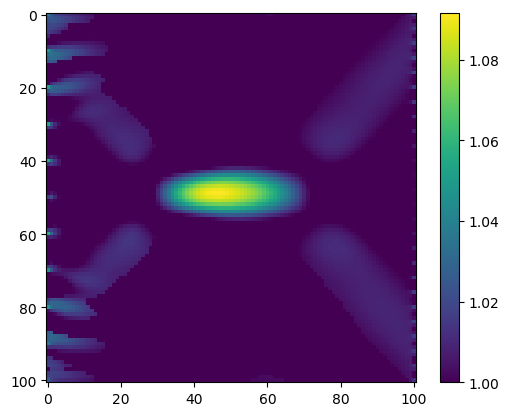

PyObject <matplotlib.colorbar.Colorbar object at 0x143520ac8>

In [13]:
imshow(reshape(xxx,Nx,Ny)); colorbar()

In [67]:
xxx1, fff = gradient_descent(obj_fn_gd, xxx, 0.1, 10, 1, 1.2; rho=0.5, c=1e-3, maxSearchTime=2);

Main iteration: 1
Start line search, fk: 1.1099059249977372. fk1: 1.1207650876696873
Search time: 1. alpha: 0.005. fk1: 1.1128291636469472
Search time: 2. alpha: 0.0025. fk1: 1.110736373959204
Search time: 3. alpha: 0.00125. fk1: 1.11016280628303
Search time: 4. alpha: 0.000625. fk1: 1.1099947124385503
Search time: 5. alpha: 0.0003125. fk1: 1.1099403970817598
Line search failed. Search time: 5. Try to decrease search coef alpha, rho, c.
Line search Failed. Try decrease line search coef alpha. Interupt.
--------------------------------


In [66]:
xkk, fkk, gradkk = line_search_backtracking(obj_fn_gd, xxx, fk, gradk, 0.01, 1, 1.2; rho=0.9, c=1e-3, maxSearchTime=5);

Start line search, fk: 1.3083493489058173. fk1: 1.1559838563352147
Line search succeed. Search time: 0.


In [68]:
fxxx, gradxxx = obj_fn_gd(xxx);
println(fxxx)

1.1099059249977372


In [70]:
pk = -gradxxx
alpha = 0.01
xkk = xxx+alpha*pk
xkk[findall(ind->ind<1,xxx)] .= 1
xkk[findall(ind->ind>1.2,xxx)] .= 1.2
@time fkxxx1, gradxxx1 = obj_fn_gd(xkk)
println(fkxxx1)

 17.113595 seconds (1.21 M allocations: 21.962 GiB, 27.23% gc time)
1.1207650876696873


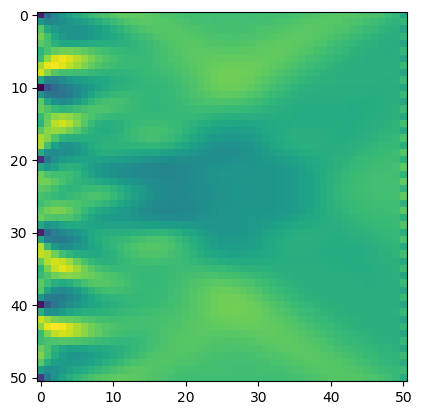

PyObject <matplotlib.image.AxesImage object at 0x144f20940>

In [71]:
imshow(reshape(gradxxx1, Nx, Ny))